In [5]:
import os
from random import choice, seed
import matplotlib.pyplot as plt 
import numpy as np
from screenplay_parsing import *

folder_name = "data/input/scripts_imsdb"
screenplay_name = choice(os.listdir(folder_name))
script_path = os.path.join(folder_name, screenplay_name)

In [6]:
characterized_indent_levels = {}
lines = []
indents = []

def characterize_indent_levels(
    lines: List[str], indents: List[int]
) -> Dict[int, label]:
    """Given a script (or an extract of the script) as a list of lines, we try to
    identify for each level of indentation which label it should have. This method
    relies on the hypothesis that lines with the same indentation level all have
    the same label. The type of an indent level is identified using the number of
    keywords specific to a label as well as the frequency of capitalized letters
    and the mean length of words.

    Args:
        lines (List[str]): list of lines
        indents (List[int]): list of the number of white spaces found before
            the text in each line of lines

    Returns:
        Dict[int, label]: a dictionnary containing the label assigned to each
            indentation level (number of whitespaces being the keys)
    """

    relevant_indent_levels, groups = group_lines_by_indent_level(
        lines, indents, minimum_occurences=0
    )
    mean_text_lengths = mean_text_length_in_groups(groups)
    capitalized_frequency = frequency_capitalized_in_groups(groups)
    characters_keywords_occurences = occurences_keywords_in_groups(
        groups, CHARACTER_KEYWORDS
    )
    scenes_beginning_keywords_occurences = occurences_keywords_in_groups(
        groups, BEGINNING_SCENES_KEYWORDS
    )
    scenes_ending_keywords_occurences = occurences_keywords_in_groups(
        groups, ENDING_SCENES_KEYWORDS
    )
    meta_keywords_occurences = occurences_keywords_in_groups(groups, META_KEYWORDS)
    dialogues_keywords_occurences = occurences_keywords_in_groups(
        groups, DIALOGUE_KEYWORDS
    )

    result = {}
    
    for i, group in enumerate(groups):
        indent_level = relevant_indent_levels[i]
        if indent_level == -1:
            result[indent_level] = label.EMPTY_LINE
        elif characters_keywords_occurences[i] > 0:
            result[indent_level] = label.CHARACTER
        elif scenes_beginning_keywords_occurences[i] > 0:
            result[indent_level] = label.SCENES_BOUNDARY_AND_DESCRIPTION
        elif scenes_ending_keywords_occurences[i] / len(group) > 0.8:
            result[indent_level] = label.SCENES_BOUNDARY
        elif meta_keywords_occurences[i] / len(group) > 0.75:
            result[indent_level] = label.METADATA
        elif capitalized_frequency[i] > 0.9 and mean_text_lengths[i] < 10:
            result[indent_level] = label.CHARACTER
        elif dialogues_keywords_occurences[i] > 0:
            result[indent_level] = label.DIALOGUE
        else:
            result[indent_level] = label.UNKNOWN

    all_lists = {"In": relevant_indent_levels, 
    "Re":[tag.value for tag in result.values()],
    "Le":mean_text_lengths, 
    "Nb":[len(group) for group in groups],
    "Ca":capitalized_frequency, 
    "Ch":characters_keywords_occurences, 
    "SB":scenes_beginning_keywords_occurences, 
    "SE":scenes_ending_keywords_occurences, 
    "Me":meta_keywords_occurences, 
    "Di":dialogues_keywords_occurences}

    print_several_lists(list(all_lists.keys()), all_lists.values())

    return result


def tag_script(script_path: str, extract = False) -> Tuple[List[List[str]], List[label]]:
    """Assign a label to each line of a script.

    Args:
        script_path (str): path of the script

    Returns:
        Tuple[List[List[str]], List[label]]: First element of the tuple is
            a list of scenes, each scene being a list of lines. The second
            element returned is the list of labels for each line.
    """
    with open(script_path) as f:
        screenplay = f.read()

    lines = screenplay.split("\n")
    scenes = find_scenes(lines)

    indents = get_indents_list(lines)
    plt.hist(indents, bins = max(indents) + 1, log=True)
    plt.show()
    # We remove the first and last scenes (which often contain the title of
    # the movie etc.), then we assign a label to each indent level
    if len(scenes) > 2:
        middle_indents = indents[len(scenes[0]) : -len(scenes[-1])]
        middle_lines = sum(scenes[1:-1], [])
    else:
        middle_indents = indents
        middle_lines = lines

    characterized_indent_levels = characterize_indent_levels(
        middle_lines, middle_indents
    )
    tags = []
    for scene in scenes:
        tags.append(tag_lines(scene, characterized_indent_levels))

    if extract : 
        print_extract_of_each_indent_level(characterized_indent_levels, middle_lines, middle_indents)

    return lines, characterized_indent_levels, indents

def print_extract_of_each_indent_level(characterized_indent_levels, lines, indents, length=6):
    for key, value in characterized_indent_levels.items():
        if value != label.EMPTY_LINE:
            print(f"\n****** {value.name} | {key} ******")
            lines_idxs = np.where(np.array(indents) ==key)[0]
            for i in range(min(length, len(lines_idxs))):
                print(lines[lines_idxs[i]])


G.I.-Jane.txt


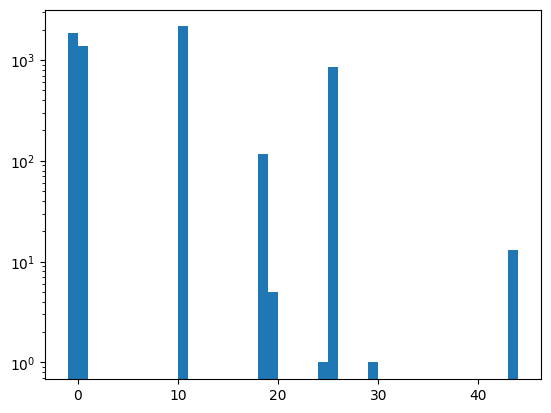

In : [    0,    -1,    25,    10,    18,    19,    44, ]
Re : [   SN,     E,     C,     D,     M,     M,     S, ]
Le : [42.78,   0.0,  7.53, 27.57, 13.57,   9.8,   8.8, ]
Nb : [ 1366,  1773,   842,  2151,   116,     5,    10, ]
Ca : [ 0.18,     0,   1.0,  0.06,  0.01,  0.03,   1.0, ]
Ch : [    0,     0,    30,     0,     0,     0,     0, ]
SB : [  182,     0,     0,     0,     0,     0,     0, ]
SE : [    1,     0,     0,     0,     0,     0,    10, ]
Me : [    1,     0,    36,     0,   116,     5,     0, ]
Di : [   20,     0,     0,   337,     0,     0,     0, ]

****** SCENES_BOUNDARY_AND_DESCRIPTION | 0 ******
INT.  SENATE HEARING ROOM - CAPITOL BLDG. - DAY
Blinding in their white uniforms, naval flag officers sit
in the audience, showing their support for THEODORE HAYES,
a 50-year-old civilian.  This is his confirmation hearing.
Reading from prepared material:
At the center of a dais, LILLIAN DEHAVEN leans back to

****** CHARACTER | 25 ******
                         HAYES
       

In [7]:
print(screenplay_name)
lines, characterized_indent_levels, indents = tag_script(script_path, extract = True)

In [ ]:
i = 14
print_extract_of_each_indent_level({i:characterized_indent_levels[i]}, lines, indents, length=10000)

In [ ]:
markdown_color_script(script_path)